In [1]:
!pip3 install contextily

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: C:\Users\Bartek\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [1]:
from itertools import chain
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd
import random
from shapely.geometry import box, Point, LineString, Polygon, MultiPolygon
import contextily as cx


BASEMAP_SOURCE = cx.providers.CartoDB.Positron
HEX_ALPHA = "4F"
POINT_PLOT_KWDS = {"marker": "D", "color": "black", "markersize": 20}
plt.rcParams['figure.dpi'] = 50

In [2]:
bbox = [19.909200668334964,50.06127149591537,19.92900609970093,50.072524465016656]  # bbox Berlin
minx, miny, maxx, maxy = bbox
poly_berlin = box(*bbox)

def random_coordinates(n, min_dist, max_dist):
    assert min_dist < max_dist # make sure parameters are valid

    coordinates = []
    for _ in range(n):
        counter = 0
        in_poly = False
        while not in_poly:
            counter += 1
            x = random.uniform(minx, maxx)
            y = random.uniform(miny, maxy)
            p = Point(x, y)
            if poly_berlin.contains(p):
                if coordinates:
                    if not min_dist < p.distance(Point(coordinates[-1])) < max_dist:
                        continue
                coordinates.append([x, y])
                in_poly = True
            if counter > 1000:
                raise ValueError("Distance settings are too restrictive. Try a wider range and remember it's in degrees.")

    return coordinates

In [3]:
route_amount = 100
input_pairs = [random_coordinates(n=2, min_dist=0.01, max_dist=0.02) for i in range(route_amount)]
print(input_pairs)

[[[19.90959151732369, 50.06978663614924], [19.92115835196118, 50.0710912272672]], [[19.911143584254525, 50.072144991881665], [19.92856881582781, 50.067318165962675]], [[19.909383805403372, 50.069021581444325], [19.927669497503754, 50.06922985683385]], [[19.91114563539387, 50.067036669567536], [19.92741678810151, 50.069403860510285]], [[19.922599445043865, 50.06374310269489], [19.91192869282587, 50.07054835233591]], [[19.920150666122346, 50.06907174343745], [19.912105207966942, 50.06134716001736]], [[19.91419449705979, 50.07105061589959], [19.925928737291876, 50.06993108291388]], [[19.923343399225637, 50.06626200963825], [19.911313668377353, 50.07040646875247]], [[19.91334558970809, 50.07215054747093], [19.927931460062485, 50.07054991178214]], [[19.92427791984114, 50.062162879574956], [19.918412423932793, 50.07214529854323]], [[19.92389561352732, 50.06182312999374], [19.927402367106517, 50.07185682878156]], [[19.921812859790542, 50.0669969361572], [19.90956806795487, 50.07187464397961]]

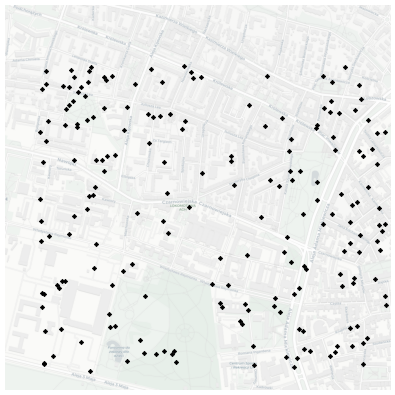

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
img, ext = cx.bounds2img(*bbox, ll=True, source=BASEMAP_SOURCE)
_ = ax.imshow(img, extent=ext)

for pair in input_pairs:
    input_df = gpd.GeoDataFrame(geometry=[Point(x,y) for x,y in pair], crs="EPSG:4326").to_crs("EPSG:3857")
    input_df.plot(ax=ax, **POINT_PLOT_KWDS)

_ = ax.axis("off")


In [7]:
routers = {
    'graphhopper': {
        'api_key': 'a54e0dd9-06ab-4bb8-af69-102402242300',
        'display_name': 'GraphHopper',
        'profile': 'foot',
        'color': '#417900',
        'isochrones': True
    }
}

In [8]:
!pip3 install routingpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
                                              0.0/84.4 kB ? eta -:--:--
     ---------------------------------------- 84.4/84.4 kB 1.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: C:\Users\Bartek\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [8]:
from routingpy.routers import get_router_by_name

dict_ = {"router": [], "distance": [], "duration": []}
geometries = []
for router in routers:

    api = get_router_by_name(router)(api_key=routers[router]['api_key'])

    for coords_pair in input_pairs:

        # just from A to B without intermediate points
        route = api.directions(
            profile=routers[router]['profile'],
            locations=coords_pair
        )
        # Access the route properties with .geometry, .duration, .distance
        distance, duration = route.distance / 1000, int(route.duration / 60)
        dict_["router"].append(router)
        dict_["distance"].append(distance)
        dict_["duration"].append(duration)
        geometries.append(LineString(route.geometry,))

    print("Calulated {}".format(router))

routes_df = gpd.GeoDataFrame(dict_, geometry=geometries, crs="EPSG:4326").to_crs("EPSG:3857")

Calulated graphhopper


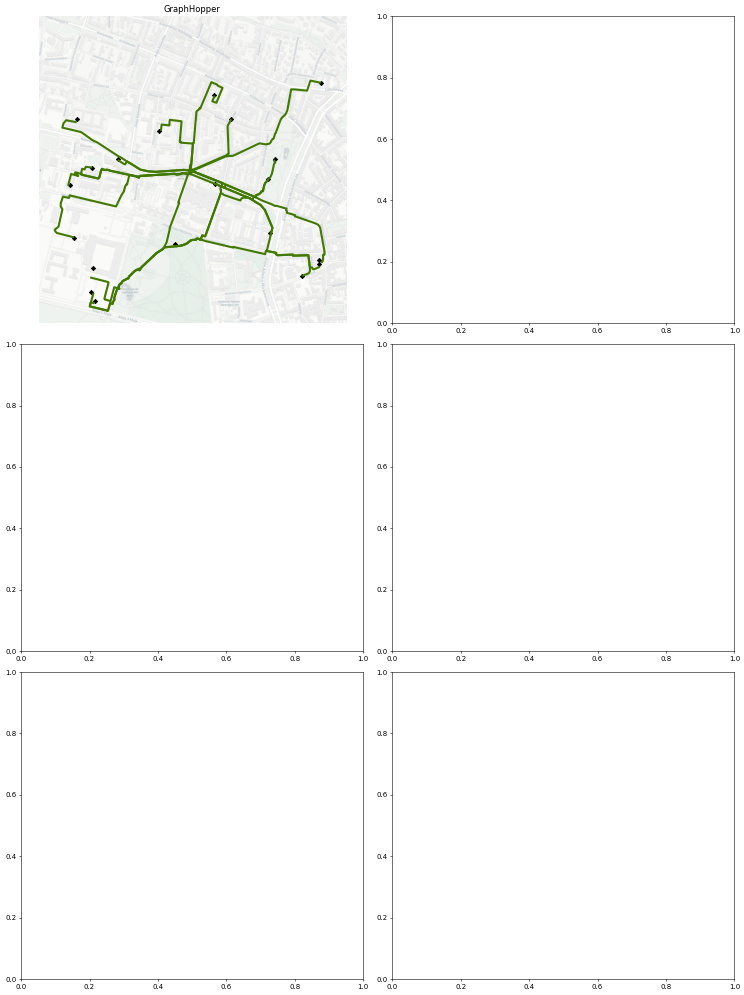

In [10]:
fig, axs = plt.subplots(3,2, figsize=(15,20))
img, ext = cx.bounds2img(*bbox, ll=True, source=BASEMAP_SOURCE)
for idx, router in enumerate(routers):
    ax = axs.flatten()[idx]
    _ = ax.imshow(img, extent=ext)
    routes_df.query(f"router == '{router}'").plot(
        ax=ax, linewidth=3,
        color=routers[router]["color"]
    )
    for pair in input_pairs:
        input_df = gpd.GeoDataFrame(geometry=[Point(x,y) for x,y in pair], crs="EPSG:4326").to_crs("EPSG:3857")
        input_df.plot(ax=ax, **POINT_PLOT_KWDS)

    _ = ax.axis("off")
    ax.set_title(routers[router]['display_name'])

fig.tight_layout()

In [11]:
for pair in input_pairs:
    input_df = gpd.GeoDataFrame(geometry=[Point(x,y) for x,y in pair], crs="EPSG:4326").to_crs("EPSG:3857")
    print(routes_df['geometry'])
    print(pair)

0    LINESTRING (2216344.345 6457472.683, 2216208.5...
1    LINESTRING (2218161.079 6457165.743, 2218210.0...
2    LINESTRING (2217596.689 6458414.382, 2217586.6...
3    LINESTRING (2217933.987 6458091.799, 2217947.3...
4    LINESTRING (2217470.898 6457897.562, 2217514.3...
5    LINESTRING (2218310.247 6458704.024, 2218227.8...
6    LINESTRING (2216692.775 6458090.065, 2216736.1...
7    LINESTRING (2217464.219 6458601.694, 2217446.4...
8    LINESTRING (2216365.496 6458390.101, 2216282.0...
9    LINESTRING (2217154.751 6457401.583, 2217188.1...
Name: geometry, dtype: geometry
[[19.909752521842705, 50.06458731448392], [19.9236144205769, 50.06730564524679]]
0    LINESTRING (2216344.345 6457472.683, 2216208.5...
1    LINESTRING (2218161.079 6457165.743, 2218210.0...
2    LINESTRING (2217596.689 6458414.382, 2217586.6...
3    LINESTRING (2217933.987 6458091.799, 2217947.3...
4    LINESTRING (2217470.898 6457897.562, 2217514.3...
5    LINESTRING (2218310.247 6458704.024, 2218227.8...
6    LI

In [68]:
from datetime import datetime, timedelta
import random

routes_df_wcf = gpd.GeoDataFrame(dict_, geometry=geometries)

outputData = pd.DataFrame(columns = ["time","longitude","latitude"])

for route in routes_df_wcf['geometry']:
    l = route.length + 0.0001
    start_datetime = datetime(2023, 12, 10, 17, 50) + timedelta(seconds=random.randrange(0, 1200))
    for dist in np.arange(0, l, 0.0001):
        currentLoc = route.interpolate(dist)
        outputData.loc[len(outputData.index)] = [start_datetime + timedelta(seconds=dist*100000), currentLoc.x, currentLoc.y] 


In [69]:
outputData.to_csv("routes_multiple.csv")

In [70]:
outputData

,time,longitude,latitude
0,2023-12-10 17:55:39,19.909760,50.064610
1,2023-12-10 17:55:49,19.909661,50.064626
2,2023-12-10 17:55:59,19.909563,50.064642
3,2023-12-10 17:56:09,19.909464,50.064659
4,2023-12-10 17:56:19,19.909365,50.064675
...,...,...,...
1704,2023-12-10 18:13:45,19.927008,50.063162
1705,2023-12-10 18:13:55,19.927105,50.063189
1706,2023-12-10 18:14:05,19.927201,50.063216
1707,2023-12-10 18:14:15,19.927297,50.063243


In [12]:
import numpy as np
from scipy.interpolate import interp1d

data = [
    [19.914242, 50.06847],
    [19.91461, 50.06843],
    [19.914668, 50.068027],
    [19.914696, 50.067962],
    [19.914911, 50.067698],
    [19.914899, 50.067664],
    [19.915102, 50.06764],
    [19.91561, 50.067625],
    [19.917633, 50.067716],
    [19.918039, 50.067686],
    [19.917962, 50.067534],
    [19.918093, 50.067522],
    [19.918016, 50.067439],
    [19.917884, 50.067197],
    [19.918095, 50.067147],
    [19.918113, 50.067181]
]
data = route_geo[0]
print(data)

# Separate latitude and longitude
longitude, latitude = zip(*data)

# Create an interpolation function for latitude
interp_latitude = interp1d(longitude, latitude, kind='linear', fill_value='extrapolate')

# Generate more new longitude values for interpolation
new_longitude = np.linspace(min(longitude), max(longitude), 500)

# Perform interpolation
new_latitude = interp_latitude(new_longitude)

data = []
# Print the latitude and longitude of the interpolated points
for lon, lat in zip(new_longitude, new_latitude):
    print(f"[{lon}, {lat}]")
    data.append([lon, lat])
print(data)

NameError: name 'route_geo' is not defined

In [ ]:
import pandas as pd
from datetime import datetime, timedelta


# Convert your data to a pandas DataFrame
df = pd.DataFrame(data, columns=["Latitude", "Longitude"])

# Set the start datetime
start_datetime = datetime(2023, 12, 10, 20, 0)

# Calculate the time difference between each point
time_difference = timedelta(minutes=5) / len(df)

# Add the datetime column
df["Datetime"] = [start_datetime + i * time_difference for i in range(len(df))]

# Print the resulting DataFrame
print(df)

df.to_csv('points.csv', index=False)



      Latitude  Longitude                Datetime
0    19.914242  50.068470 2023-12-10 20:00:00.000
1    19.914250  50.068469 2023-12-10 20:00:00.600
2    19.914258  50.068468 2023-12-10 20:00:01.200
3    19.914265  50.068467 2023-12-10 20:00:01.800
4    19.914273  50.068467 2023-12-10 20:00:02.400
..         ...        ...                     ...
495  19.918082  50.067555 2023-12-10 20:04:57.000
496  19.918090  50.067532 2023-12-10 20:04:57.600
497  19.918097  50.067152 2023-12-10 20:04:58.200
498  19.918105  50.067166 2023-12-10 20:04:58.800
499  19.918113  50.067181 2023-12-10 20:04:59.400

[500 rows x 3 columns]
